In [1]:
using LinearAlgebra
using Plots
using Statistics
pyplot();

using Pkg
Pkg.activate("../")

using Revise
using ExpFamilyDistributions
using BayesianModels

 Activating environment at `~/BUT/Repositories/myForks/BayesianModels/Project.toml`
┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/landini/.julia/packages/Revise/XFtoQ/src/Revise.jl:1306


### Synthetic data test

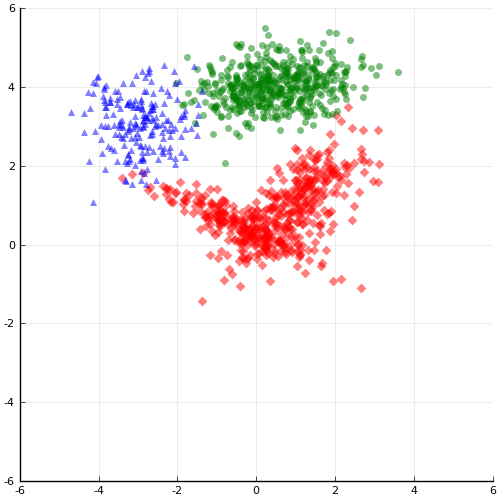

In [2]:
# Class 1
μ1 = [1., 1.]
Σ1 = [0.7 0.5; 0.5 0.7]

# Class 2
μ2 = [-0.5, 0.5]
Σ2 = [1 -0.5; -0.5 0.3]
μ3 = [0.5, 4.]
Σ3 = 0.5 * [2. 0.25; 0.25 0.5]

# Class 3
μ4 = [-3, 3]
Σ4 = .5 * [1. 0.; 0. 1.]

function samplenormal(μ, Σ, size)
    L = cholesky(Σ).L
    μ .+ L * randn(2, size)
end

sizecoeff = 100

x1_test = hcat(samplenormal(μ1, Σ1, 3* sizecoeff), samplenormal(μ2, Σ2, 2 * sizecoeff))
x2_test = samplenormal(μ3, Σ3, 5  * sizecoeff)
x3_test = samplenormal(μ4, Σ4, 2  * sizecoeff)

X_test = hcat(x1_test, x2_test, x3_test)
z_test = vcat(ones(Int64, size(x1_test, 2)), ones(Int64, size(x2_test, 2)) * 2,  
         ones(Int64, size(x3_test, 2)) * 3)


function plotdata!(p, x1_test, x2_test, x3_test)
    scatter!(p, x1_test[1, :], x1_test[2, :], label=nothing, marker = (:diamond, 5, 0.5, :red, stroke(0)))
    scatter!(p, x2_test[1, :], x2_test[2, :], label=nothing, marker = (:circle, 5, 0.5, :green, stroke(0)))
    scatter!(p, x3_test[1, :], x3_test[2, :], label=nothing, marker = (:utriangle, 5, 0.5, :blue, stroke(0)))
end

p = plot(size=(500, 500), xlims=(-6, 6), ylims=(-6, 6))
plotdata!(p, x1_test, x2_test, x3_test)

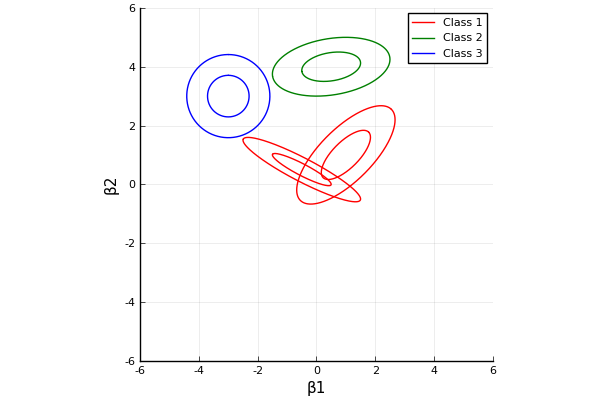

In [3]:
# Plot of distribution
ppost_dist = plot(xlims = (-6, 6), ylims = (-6, 6),
              aspect_ratio=:equal, xlabel = "β1",
              ylabel = "β2")
plotnormal2d(ppost_dist, μ1, Σ1, ncontours = 2, color = :red, label="Class 1")
plotnormal2d(ppost_dist, μ2, Σ2, ncontours = 2, color = :red)
plotnormal2d(ppost_dist, μ3, Σ3, ncontours = 2, color = :green, label="Class 2")
plotnormal2d(ppost_dist, μ4, Σ4, ncontours = 2, color = :blue, label="Class 3")

## Synthetic data train

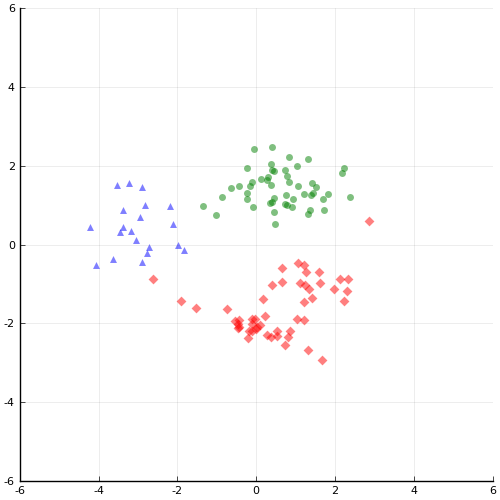

In [4]:
# Class 1
μ1 = [1., 1.]
Σ1 = [0.7 0.5; 0.5 0.7]

# Class 2
μ2 = [-0.5, 0.5]
Σ2 = [1 -0.5; -0.5 0.3]
μ3 = [0.5, 4.]
Σ3 = 0.5 * [2. 0.25; 0.25 0.5]

# Class 3
μ4 = [-3, 3]
Σ4 = .5 * [1. 0.; 0. 1.]

function samplenormal(μ, Σ, size)
    L = cholesky(Σ).L
    μ .+ L * randn(2, size)
end

sizecoeff = 10

x1_train = hcat(samplenormal(μ1, Σ1, 3* sizecoeff), samplenormal(μ2, Σ2, 2 * sizecoeff))
x2_train = samplenormal(μ3, Σ3, 5  * sizecoeff)
x3_train = samplenormal(μ4, Σ4, 2  * sizecoeff)

X_train = hcat(x1_train, x2_train, x3_train)
z_train = vcat(ones(Int64, size(x1_train, 2)), ones(Int64, size(x2_train, 2)) * 2,  
         ones(Int64, size(x3_train, 2)) * 3)


# Normalize both train and test with respect to the mean of train
train_mean = Statistics.mean(X_train, dims=2)
X_train .-= train_mean
X_test_norm = X_test .- train_mean
x1_train .-= train_mean
x2_train .-= train_mean
x3_train .-= train_mean
x1_test_norm = x1_test .- train_mean
x2_test_norm = x2_test .- train_mean
x3_test_norm = x3_test .- train_mean


function plotdata!(p, x1_train, x2_train, x3_train)
    scatter!(p, x1_train[1, :], x1_train[2, :], label=nothing, marker = (:diamond, 5, 0.5, :red, stroke(0)))
    scatter!(p, x2_train[1, :], x2_train[2, :], label=nothing, marker = (:circle, 5, 0.5, :green, stroke(0)))
    scatter!(p, x3_train[1, :], x3_train[2, :], label=nothing, marker = (:utriangle, 5, 0.5, :blue, stroke(0)))
end

p = plot(size=(500, 500), xlims=(-6, 6), ylims=(-6, 6))
plotdata!(p, x1_train, x2_train, x3_train)

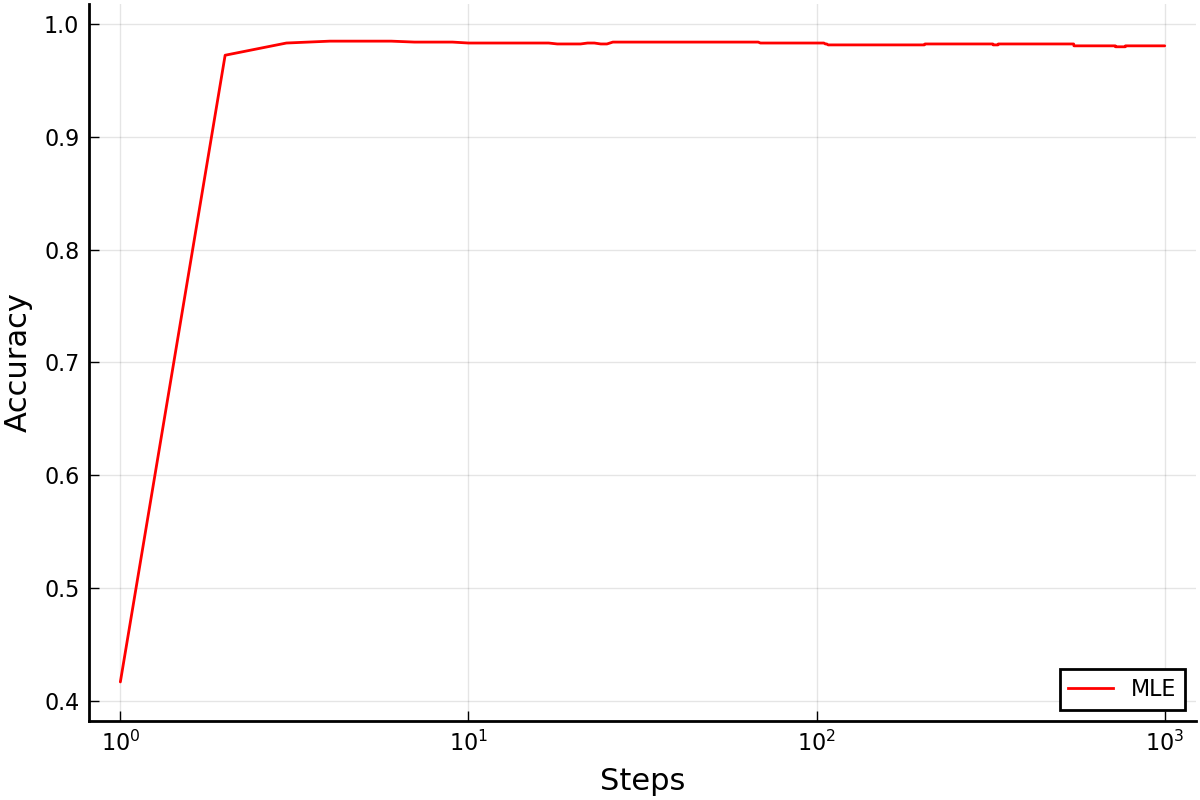

In [5]:
include("LR_MLE.jl")
n_classes = 3
steps = 1000
η = 0.01
optimizer = "SGD"
# βs_MLE will contain the βs for each iteration
βs_MLE = train_MLE(X_train, z_train, n_classes, steps, η, optimizer)

# Evaluate
acc = zeros(Float64, steps+1)
for i = 1:steps+1
    acc[i] = accuracy_MLE(βs_MLE[i,:,:], X_test_norm, z_test)
end

plot(1:steps+1, 
    acc, 
    xaxis=:log, 
    linecolor=:red, 
    ylim = [0.4, 1],
    xlabel = "Steps",
    ylabel = "Accuracy",
    label="MLE",
    dpi=200)

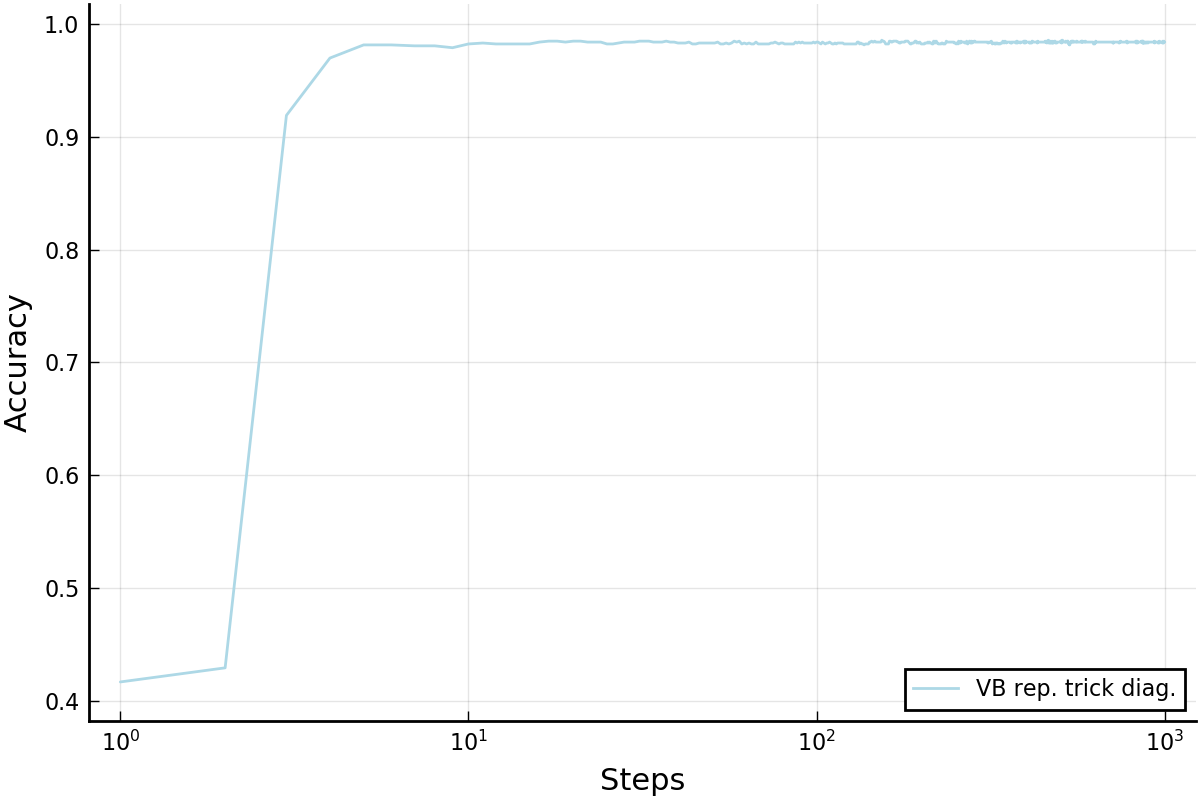

In [6]:
include("LR_VB_rep_trick_diag.jl")
n_classes = 3
steps = 1000
η = 0.01
optimizer = "SGD"
n_samples = 10
# μs, λs will be the parameters for each iteration
μs, λs = train_VB_rep_trick_diag(X_train, z_train, n_classes, steps, η, optimizer, n_samples)

# Evaluate
acc = zeros(Float64, steps+1)
for i = 1:steps+1
    acc[i] = accuracy_marginal(μs[i,:,:], λs[i,:,:], X_test_norm, z_test)
end

plot(1:steps+1, 
    acc, 
    xaxis=:log, 
    linecolor=:lightblue, 
    ylim = [0.4, 1],
    xlabel = "Steps",
    ylabel = "Accuracy",
    label="VB rep. trick diag.",
    dpi=200)

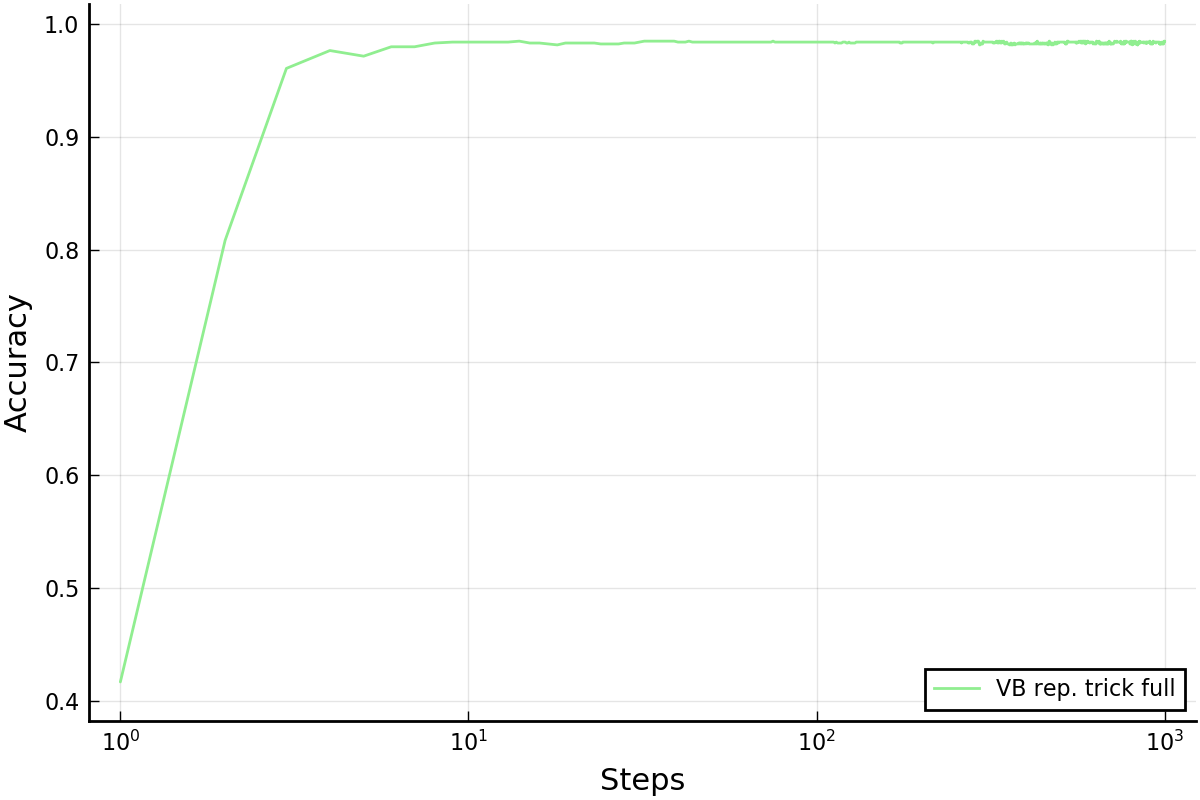

In [7]:
include("LR_VB_rep_trick_full.jl")
n_classes = 3
steps = 1000
η = 0.01
optimizer = "SGD"
n_samples = 10
# μs, Us, λs will be the parameters for each iteration
μs, Us, λs = train_VB_rep_trick_diag(X_train, z_train, n_classes, steps, η, optimizer, n_samples)

# Evaluate
acc = zeros(Float64, steps+1)
for i = 1:steps+1
    acc[i] = accuracy_marginal(μs[i,:,:], Us[i,:,:,:], λs[i,:,:], X_test_norm, z_test)
end

plot(1:steps+1, 
    acc, 
    xaxis=:log, 
    linecolor=:lightgreen, 
    ylim = [0.4, 1],
    xlabel = "Steps",
    ylabel = "Accuracy",
    label="VB rep. trick full",
    dpi=200)

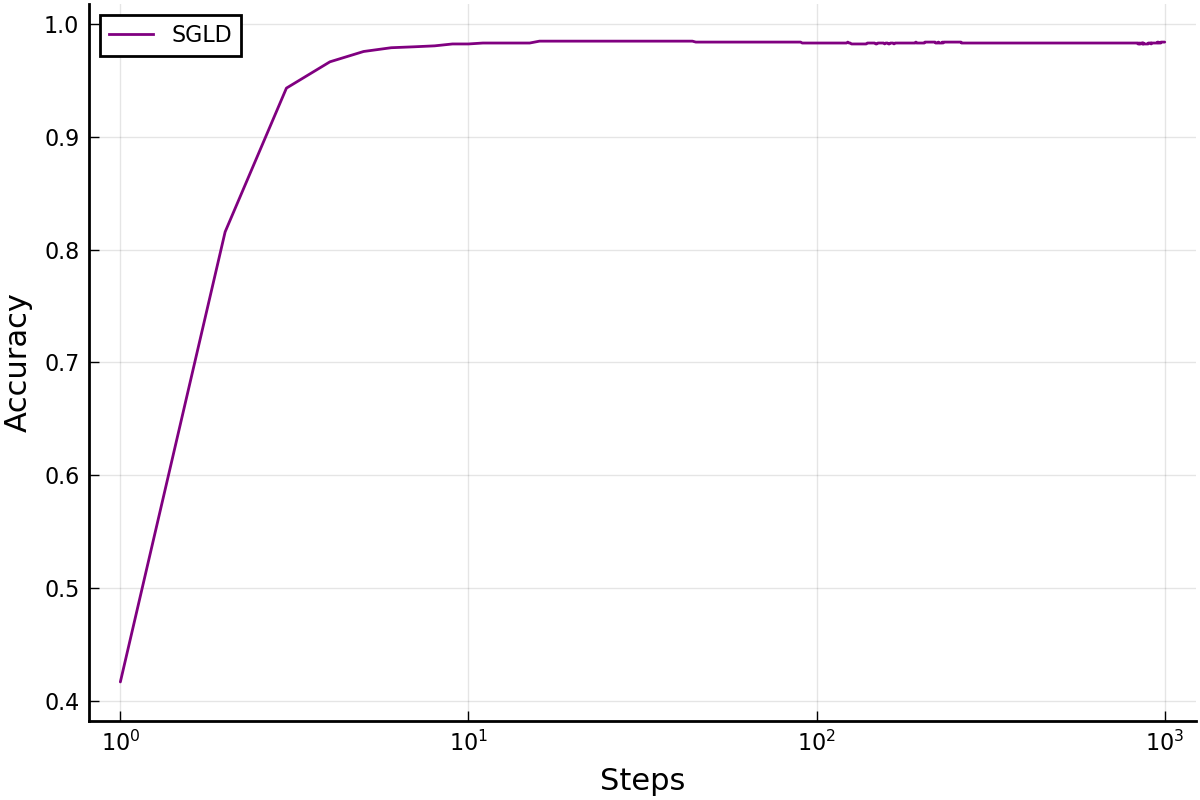

In [8]:
include("LR_SGLD.jl")
n_classes = 3
steps = 1000
η = 0.01
n_samples = 10
# βs_SGLD will contain the βs for each iteration
βs_SGLD = train_SGLD(X_train, z_train, n_classes, steps, η, n_samples)

# Evaluate
acc = zeros(Float64, steps+1)
for i = 1:steps+1
    acc[i] = accuracy_SGLD(βs_SGLD[:,i,:,:], X_test_norm, z_test)
end

plot(1:steps+1, 
    acc, 
    xaxis=:log, 
    linecolor=:purple, 
    ylim = [0.4, 1],
    xlabel = "Steps",
    ylabel = "Accuracy",
    label="SGLD",
    dpi=200)